## Tensor Factorization for Baseball performance prediction

In this notebook we are going to try to predict the outcome of an "at-bat" in a baseball game. In a super simple world, the outcome of an at-bat depends on the batter, the pitcher, and how many outs there are. Of course, there are many more relevant factors, but these are the ones we are going to focus on today. Thus, we have a learning problem: given a batter, pitcher, and how many outs there are, can we predict the number of bases the batter is going to slug for? 

At first glance, it must seem like stats about the batters and pitchers must be given (i.e. batting average, strikeouts per 9 innings, and more). However, we are going to try to predict these outcomes without using anything except for previous at-bats. There are a couple challenges here. First, we need to simultaneously learn representations for the pitchers and batters. Second, only a few of the total combinations of at-bats are observed (not all pitchers face all batters). Finally, the at-bats which are observed are noisy (an at-bat is inherently probabilistic).

Before we move on, let's first some do some data preprocessing. Note that the data here is part of a larger project that I am working on, and due to licensing issues, I cannot provide the dataset :(

In [3]:
from model.dataset import *

db_path = 'baseball.db'
database = master_dataset(db_path)

In [70]:
df = database.get_plays(start_date='2001-04-10', end_date='2001-10-01')
df

,game_id,pitcher,player_id,outcome,cur_outs,date
0,ANA200104110,ortir002,greer001,flyout,0,2001-04-11
1,ANA200104110,ortir002,velar001,strikeout,1,2001-04-11
2,ANA200104110,ortir002,rodra001,strikeout,2,2001-04-11
3,ANA200104110,glynr001,erstd001,single,0,2001-04-11
4,ANA200104110,glynr001,joynw001,flyout,0,2001-04-11
...,...,...,...,...,...,...
184371,SLN200109300,loisr001,vinaf001,walk,1,2001-09-30
184372,SLN200109300,loisr001,polap001,groundout,1,2001-09-30
184373,SLN200109300,klins002,gileb002,groundout,0,2001-09-30
184374,SLN200109300,timlm001,ramia001,walk,1,2001-09-30


In [71]:
# Processing step
df['player_id']
# Need to create a tensor [player, pitcher, outs, outcome]
# All of the outs are going to be encoded by 0

num_up = 0
num_ub = 0
# Create unique IDs for pitchers and batters
up = {}
ub = {}
for idx, row in df.iterrows(): 
    if row[1] not in up: 
        up[row[1]] = num_up
        num_up += 1
    if row[2] not in ub: 
        ub[row[2]] = num_ub
        num_ub += 1

In [293]:
import tensorly as tl
import numpy as np
from datetime import datetime



def outcome_to_num(outcome): 
    if 'out' in outcome: 
        return 0
    elif outcome == 'single': 
        return 1
    elif outcome == 'double': 
        return 2
    elif outcome == 'triple': 
        return 3
    return 4

def get_outcomes(df, start_date, end_date): 
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

    mask = np.ones((len(up), len(ub), 3))
    outcomes = np.zeros((len(up), len(ub), 3))

    for idx, row in df.iterrows():
        date = datetime.strptime(row[5], '%Y-%m-%d')
        if date >= start_date and date < end_date: 
            pitcher = up[row[1]]
            batter = ub[row[2]]
            outcome = outcome_to_num(row[3])
            num_outs = row[4]
            mask[pitcher, batter, num_outs] += 1
            outcomes[pitcher, batter, num_outs] += outcome
    mask = np.reciprocal(mask.astype(float))
    outcomes = outcomes * mask
    mask = mask < 1
    return mask, outcomes

train_mask, train_outcomes = get_outcomes(df, '2001-04-10', '2001-06-25')
valid_mask, valid_outcomes = get_outcomes(df, '2001-06-25', '2001-07-25')
test_mask, test_outcomes = get_outcomes(df, '2001-07-25', '2001-10-01')

train_outcomes_mean = np.mean(train_outcomes)
train_outcomes -= train_outcomes_mean
valid_outcomes -= train_outcomes_mean
test_outcomes -= train_outcomes_mean


After our preprocessing we have 3 tensors for the training, validation, and testing. We also have 3 seperate masks which we will use later which have 1's where an at-bat takes place, and 0's where no at-bat takes place. Each tensor is 3-way where one dimension is for unique pitchers, one is for unique batters, and the last is for the number of outs currently.

Now we are ready to use tensor factorization. We want to represent each batter, pitcher, and out with some latent variables such that the outer product of the latent variables form a low rank approximation for the tensors. For more information on this topic see this great youtube video: https://www.youtube.com/watch?v=L8uT6hgMt00&t=897s. We are going to be using the Parfac decomposition because it is generally accepted that it is the most useful for finding latent variables.

In [291]:
# Some functions to help us later
def MSE(mask, outcomes, pred_outcomes):
    num = np.sum(mask)
    cur_outcomes = mask * outcomes
    cur_pred_outcomes = mask * pred_outcomes
    return np.sum(np.square(cur_outcomes - cur_pred_outcomes))/num 

def MAE(mask, outcomes, pred_outcomes):
    num = np.sum(mask)
    cur_outcomes = mask * outcomes
    cur_pred_outcomes = mask * pred_outcomes
    return np.sum(np.abs(cur_outcomes - cur_pred_outcomes))/num 

In [294]:
from tensorly.decomposition import tucker, parafac, non_negative_parafac
from tensorly import tucker_to_tensor, cp_to_tensor

ranks = [i for i in range(1, 10)]
best_MSE = None
best_rank = None
for idx, rank in enumerate(ranks): 
    core, factors = parafac(train_outcomes, init='random', rank=rank, mask=train_mask)
    pred_outcomes = cp_to_tensor((core, factors))
    cur_MSE = MSE(valid_mask, valid_outcomes, pred_outcomes)
    cur_MAE = MAE(valid_mask, valid_outcomes, pred_outcomes)
    print(f'rank: {rank}: cur_MSE: {cur_MSE}, cur_MAE: {cur_MAE}')
    if not best_MSE or cur_MSE < best_MSE: 
        best_rank = rank
        best_MSE = cur_MSE
print(best_rank)
print(best_MSE)



rank: 1: cur_MSE: 0.6138540335468257, cur_MAE: 0.625934842967713
rank: 2: cur_MSE: 0.6382752297874282, cur_MAE: 0.6269974721380241
rank: 3: cur_MSE: 0.6512445652244233, cur_MAE: 0.631457031217568
rank: 4: cur_MSE: 0.677393101880879, cur_MAE: 0.6369776572451517
rank: 5: cur_MSE: 0.6952048674635146, cur_MAE: 0.6405229256989299
rank: 6: cur_MSE: 0.7207346266064864, cur_MAE: 0.6489002456185237
rank: 7: cur_MSE: 0.7368826843555166, cur_MAE: 0.6546110299173137
rank: 8: cur_MSE: 0.740691905674849, cur_MAE: 0.6596578665196526
rank: 9: cur_MSE: 0.7708556144807547, cur_MAE: 0.6685598474090035
1
0.6138540335468257


One issue that we need to resolve is the rank of our approximation. To do this, we fit the decomposition on the first half of the MLB season and calculate the MSE on the next month. Thus, we can find the optimal rank for our approximation by choosing the one which generates the lowest MSE.

In [289]:
from tensorly.decomposition import parafac
from tensorly import cp_to_tensor


best_rank = 1
(weights, factors) = parafac(train_outcomes, best_rank, init='random', mask=train_mask)
pred_outcomes = cp_to_tensor((weights, factors))

test_MSE = MSE(test_mask, test_outcomes, pred_outcomes)
test_MAE = MAE(test_mask, test_outcomes, pred_outcomes)
print(f'test_MSE: {test_MSE}')
print(f'test_MAE: {test_MAE}')

test_MSE: 0.6575761348492685
test_MAE: 0.6239726455466582


In [311]:
# three controls
# predict just the average over the non-zero values with respect to number of outs
avg_control = np.expand_dims(np.mean(train_outcomes, axis=2), axis=2)
avg_control = np.repeat(avg_control, repeats=3, axis=2)
avg_err = MSE(test_mask, test_outcomes, avg_control)
print(f'mean control error: {avg_err}')
# predict a batters average with respect to number of outs
b_avg_control = np.expand_dims(np.mean(train_outcomes, axis=(0, 2)), axis=(0, 2))
b_avg_control = np.repeat(b_avg_control, repeats=3, axis=2)
b_avg_control = np.repeat(b_avg_control, repeats=len(up), axis=0)
b_avg_err = MSE(test_mask, test_outcomes, b_avg_control)
print(f'mean batter control error: {b_avg_err}')
# predict a pitchers average with respect to number of outs
p_avg_control = np.expand_dims(np.mean(train_outcomes, axis=(1, 2)), axis=(1, 2))
p_avg_control = np.repeat(p_avg_control, repeats=3, axis=2)
p_avg_control = np.repeat(p_avg_control, repeats=len(ub), axis=1)
p_avg_err = MSE(test_mask, test_outcomes, p_avg_control)
print(f'mean pitcher control error: {p_avg_err}')


mean control error: 0.8805045765992431
mean batter control error: 0.8814048749188713
mean pitcher control error: 0.9033417765502534


Indeed our approach is more informative than the controls!

In [286]:
mask_outcomes = test_mask * test_outcomes
mask_pred_outcomes = test_mask * pred_outcomes
diff = mask_outcomes - mask_pred_outcomes
diff = diff.flatten()
test_mask_flatten = test_mask.flatten()
diff = diff[test_mask_flatten != 0]

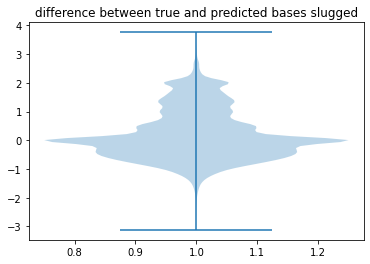

In [314]:
import matplotlib.pyplot as plt

plt.violinplot(diff)
plt.title('difference between true and predicted bases slugged')
plt.show()

# Conclusion
- Although the errors are exactly unimodal, most of the mass lies in between the 1 and -1 which indicates that the tensor decomposition is reasonable. This is supported by our small MSE and MAE.
- Indeed we can say that our MSE and MAE are small because baseball is extremely hard to predict. If we are on average only predicting about half of a base off of the true outcome, when there are 4 possible number of bases we can hit for, our model definitely contains valuable information. 
- This is further supported by the fact that we beat the different controls significantly.
- Overall this approach is promising, yet it is likely limited due to the noisy nature of baseball. There are more tensor factorization methods that are robust to noise that I will look into in the future (and maybe have to implement!)